In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import KernelPCA

from sklearn.pipeline import Pipeline

from sklearn.learning_curve import learning_curve

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load datasets
train = pd.read_csv('../data/numerai_datasets/numerai_training_data.csv')
test_df = pd.read_csv('../data/numerai_datasets/numerai_tournament_data.csv')

In [3]:
# create a feature set
features = train.columns.drop('target')

X = train[features]
y = train.target

In [4]:
# set a random seed
np.random.seed(1279)

In [5]:
# create a train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [76]:
# feature selection
select = SelectKBest(chi2, k=18)

# dimensionality reduction
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01, degree=2)

# linear model
clf = LogisticRegression(C=1.)

# extra trees classifier
# clf = ExtraTreesClassifier(n_estimators=300, max_depth=3, min_samples_split=5, n_jobs=-1)

pipeline = Pipeline([('kpca', kpca), ('clf', clf)])

In [ ]:
# cross validation
skf = StratifiedKFold(y_train_subset, n_folds=10, random_state=1)

scores = []

for k, (train, test) in enumerate(skf):
    pipeline.fit(X_train.iloc[train], y_train.iloc[train])
    score = log_loss(y_train.iloc[test], pipeline.predict_proba(X_train.iloc[test])[:, 1])
    scores.append(score)
    
    print 'Fold: %s, Class dist: %s, Log loss: %.3f ' %(k+1, np.bincount(y_train.iloc[train]), score)

Fold: 1, Class dist: [856 943], Log loss: 0.690 
Fold: 2, Class dist: [856 943], Log loss: 0.691 
Fold: 3, Class dist: [857 943], Log loss: 0.691 
Fold: 4, Class dist: [857 943], Log loss: 0.688 

In [75]:
print 'CV accuracy: %.3f +/- %.3f ' %(
            np.mean(scores), np.std(scores))

CV accuracy: 0.690 +/- 0.002 


In [25]:
## Learning curves
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipeline,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(.1, 1.0, 5),
                   cv=5,
                   scoring='log_loss',
                   n_jobs=1)

KeyboardInterrupt: 

In [60]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

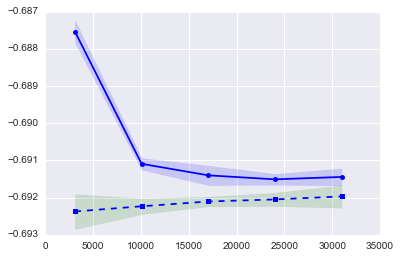

In [61]:
# plot learning curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training_accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='blue', linestyle='--',
         marker='s',
         markersize=5,
         label='validation_accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

In [47]:
## test on the hold out set
print 'Log Loss: %.3f ' %(log_loss(y_test, pipeline.predict_proba(X_test)[:, 1]))

Log Loss: 0.694 


In [63]:
## train on the full data set
pipeline.fit(X, y)

Pipeline(steps=[('select', SelectKBest(k=7, score_func=<function chi2 at 0x1158df320>)), ('clf', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [68]:
# predictions on the test set
predictions = pipeline.predict_proba(test_df[features])[:, 1]

In [69]:
# prepare submission
submission = pd.read_csv('../data/numerai_datasets/numerai_example_predictions.csv')
submission.loc[:, 'probability'] = predictions
submission.to_csv('../submissions/extra_trees_classifier.csv', index=False)